## Data of VIX index

As we have mentioned before in our project proposal, according to the assumption of the cannonical stochastic volatility model, the distribution of the volatility parameter $\sigma_\eta$ does not change with time. We will see that whether the volitility of financial market is time-invariant during covid-19.

First we will show the data of CBOE Volatility Index(VIX) during covid-19.The data was downloaded from Yahoo Finance:

In [34]:
import arviz as az
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import yfinance as yf
import os

%matplotlib inline
%config Completer.use_jedi = False

In [2]:
returns = pd.read_csv(pm.get_data("SP500.csv"), index_col="Date")
returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()
returns.head()

,Close,change
Date,,
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663
2008-05-09,1388.280029,-0.006748


In [3]:
# load sp500 and vix data use yfinance
_finance_data = yf.download("^GSPC ^VIX", start="2017-01-01", end="2021-01-11")['Adj Close']
_finance_data = _finance_data.rename({'^GSPC':'SP500', '^VIX':'VIX', '^INDIAVIX':'India_VIX'}, axis=1)
_finance_data.head(2)

[*********************100%***********************]  2 of 2 completed


,SP500,VIX
Date,,
2017-01-03,2257.830078,12.85
2017-01-04,2270.750000,11.85


We plot the graph of VIX index:

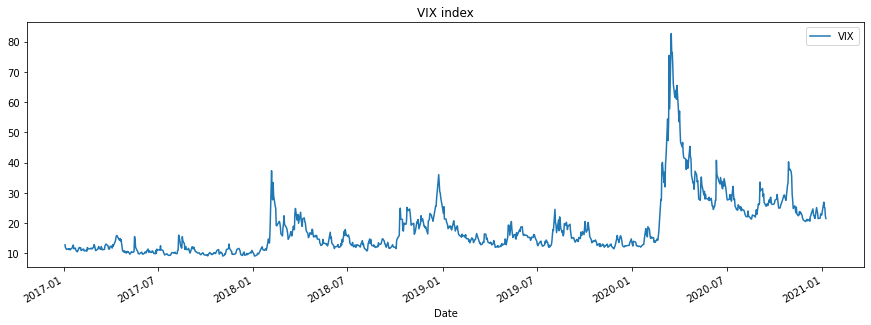

In [236]:
_finance_data.plot(y=['VIX'],use_index=True, figsize=(15,5),title="VIX Index")

In our project, we will set 2020-01-22 as the beginning of covid-19.The graph shows that:
* Before covid-19,, VIX did not fluctuate greatly.
* After covid-19 broke out, espically in the fisrt several months, VIX raised rapidly and reached a peak, which may not be consistent with the assumption that the volatility is time-invariant.

Then, our group researched on the volatility index of India, Hong Kong,Japan and Eurozone(Actually, it may be a great pity that there is no VIX index in the mainland of China, so we replace it with Hong Kong as it is one of the most important financial centers in the world and its market is closedly related to the mainland's).We downloaded those datas from Google and here are the datas:

In [241]:
IDVIX = pd.read_csv("IDIndex.csv").pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) \
.pipe(pd.DataFrame.rename, {'Close':'IDVIX'}, axis=1) \
.pipe(pd.DataFrame.set_index, ['Date']) \

IDVIX.index = IDVIX.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%d-%b-%y'))
finance_data = _finance_data.merge(IDVIX, left_index=True, right_index=True)
finance_data.head(2)

,SP500,VIX,IDVIX
Date,,,
2019-02-28,2784.489990,14.78,18.2775
2019-03-01,2803.689941,13.57,16.2750


In [242]:
VHSI = pd.read_csv("VHSI.csv").pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) \
.pipe(pd.DataFrame.rename, {'Close':'VHSI'}, axis=1) \
.pipe(pd.DataFrame.set_index, ['Date']) \

VHSI.index = VHSI.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%d-%b-%y'))
finance_data = finance_data.merge(VHSI, left_index=True, right_index=True)
finance_data.head(2)

,SP500,VIX,IDVIX,VHSI
Date,,,,
2019-02-28,2784.489990,14.78,18.2775,18.93
2019-03-01,2803.689941,13.57,16.2750,17.10


In [243]:
JPVIX = pd.read_csv("JPIndex.csv").pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) \
.pipe(pd.DataFrame.rename, {'Close':'JPVIX'}, axis=1) \
.pipe(pd.DataFrame.set_index, ['Date']) \

JPVIX.index = JPVIX.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%Y.%m.%d'))
finance_data = finance_data.merge(JPVIX, left_index=True, right_index=True)
finance_data.head(2) 

,SP500,VIX,IDVIX,VHSI,JPVIX
Date,,,,,
2019-02-28,2784.489990,14.78,18.2775,18.93,1.52
2019-03-01,2803.689941,13.57,16.2750,17.10,1.43


In [244]:
EUVIX = pd.read_csv("EUIndex.csv").pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) \
.pipe(pd.DataFrame.rename, {'Close':'EUVIX'}, axis=1) \
.pipe(pd.DataFrame.set_index, ['Date']) \

EUVIX.index = EUVIX.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%m/%d/%Y'))
finance_data = finance_data.merge(EUVIX, left_index=True, right_index=True)
finance_data.head(2) 

,SP500,VIX,IDVIX,VHSI,JPVIX,EUVIX
Date,,,,,,
2019-02-28,2784.489990,14.78,18.2775,18.93,1.52,14.78
2019-03-01,2803.689941,13.57,16.2750,17.10,1.43,13.57


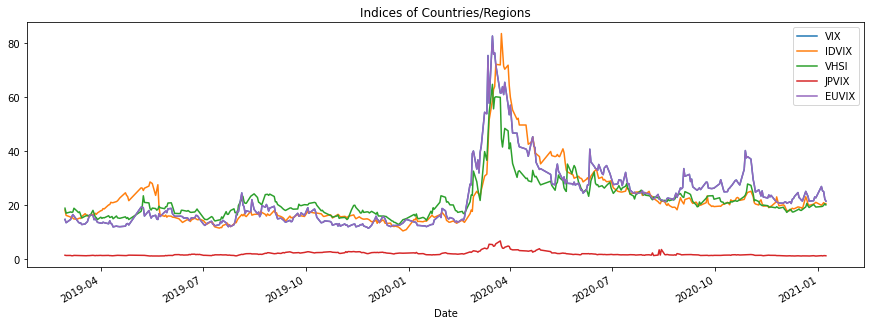

In [245]:
finance_data.plot(y=['VIX', 'IDVIX','VHSI','JPVIX','EUVIX'], use_index=True, figsize=(15,5),title='Indices of Countries/Regions')

According the the graph, all indices have a great peak after covid-19. Althouh the peak of JPVIX is not as obvious as others'(We can see that the financial market of Japan is much more stable than that of other financial market), we can also find that it also reach a peak after the covid-19 broke up in the graph which only has JPVIX:

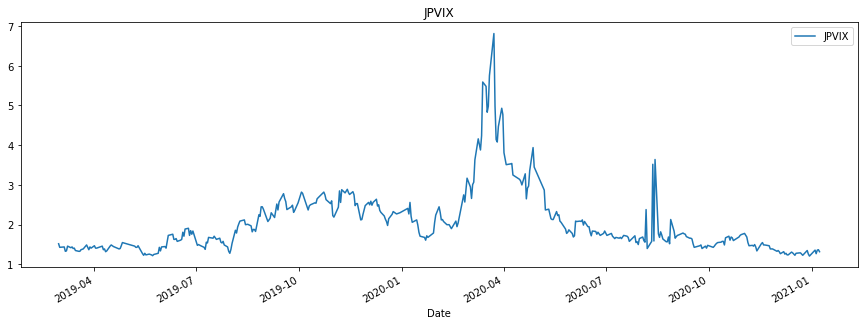

In [246]:
finance_data.plot(y=['JPVIX'], use_index=True, figsize=(15,5),title="JPVIX")

In conclusion, obviously, the vix indices of these financial market reached a great peak after the broke up of covid-19, which may be a great challenge of "time-invariant volatility" consumption. To get more details of it, we will add the data of covid-19 into our research:

## Data with covid-19

We download the data of covid-19 from Johns Hopkins Coronavirus Resource Center.By using the methods learned from our classes, we merged these data to a total dataset of all countries and regions we researched on:

In [247]:
_covid_19 =pd.read_csv(os.path.join(os.curdir, "covid.csv"))


covid_19 = _covid_19.pipe(pd.DataFrame.drop, ['Province/State', 'Lat', 'Long'], 1) \
        .pipe(pd.DataFrame.set_index, 'Country/Region').T
        
covid_19['global'] = covid_19.apply('sum', axis=1)

# calculate the cases growth in each country
covid_19_country = pd.DataFrame(index=covid_19.index)
for country in covid_19.columns.unique():
        covid_19_country['cases_growth_' + country] = np.log(covid_19[[country]].sum(axis=1).replace(0,1)).diff().rolling(14, win_type='gaussian').mean(std=3)                                  


# # calculate the cases growth in US
# covid_19['cases_growth_US'] = np.log(covid_19['US']).diff().rolling(14, win_type='gaussian').mean(std=3)


# calculate the cases growth globally
covid_19_country['cases_growth_global'] = covid_19_country.mean(axis=1)

covid_19_data = covid_19[['US', 'global']].merge(covid_19_country[['cases_growth_US', 
                                                                   'cases_growth_global', 
                                                                   'cases_growth_India',
                                                                   'cases_growth_Japan']], 
                                                 left_index=True, right_index=True)

In [248]:
_covid_19HK =pd.read_csv(os.path.join(os.curdir, "HKcovid.csv"))
covid_19HK = _covid_19HK.pipe(pd.DataFrame.drop, ['Province/State', 'Lat', 'Long'], 1) \
        .pipe(pd.DataFrame.set_index, 'Country/Region').T
covid_19_HK= np.array(np.log(covid_19HK[['Hong Kong']].sum(axis=1).replace(0,1)).diff().rolling(14, win_type='gaussian').mean(std=3))       
covid_19HK['cases_growth_HK']=covid_19_HK

In [249]:
covid_19_data=covid_19_data.merge(covid_19HK,left_index=True, right_index=True)

In [250]:
_covid_19EU =pd.read_csv(os.path.join(os.curdir, "EUcovid.csv"))


covid_19EU = _covid_19EU.pipe(pd.DataFrame.drop, ['Province/State', 'Lat', 'Long'], 1) \
        .pipe(pd.DataFrame.set_index, 'Country/Region').T
        
covid_19EU['EU'] = covid_19EU.apply('sum', axis=1)

# calculate the cases growth in each country in Eurozone
covid_19_EUcountry = pd.DataFrame(index=covid_19EU.index)
for country in covid_19EU.columns.unique():
        covid_19_EUcountry['cases_growth_' + country] = np.log(covid_19EU[[country]].sum(axis=1).replace(0,1)).diff().rolling(14, win_type='gaussian').mean(std=3)                                  


covid_19_EUcountry['cases_growth_EU'] = covid_19_EUcountry.mean(axis=1)

In [251]:
covid_19_data=covid_19_data.merge(covid_19_EUcountry,left_index=True, right_index=True)

In [252]:
covid_19_data=covid_19_data.drop(index=['Unnamed: 0'])
covid_19_data

,US,global,cases_growth_US,cases_growth_global,cases_growth_India,cases_growth_Japan,Hong Kong,cases_growth_HK,cases_growth_France,cases_growth_Germany,...,cases_growth_Spain,cases_growth_Greece,cases_growth_Slovenia,cases_growth_Malta,cases_growth_Cyprus,cases_growth_Slovakia,cases_growth_Estonia,cases_growth_Latvia,cases_growth_Lithuania,cases_growth_EU
1/22/20,1,557,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/23/20,1,655,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/24/20,2,941,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/25/20,2,1433,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/26/20,5,2118,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1/27/21,25598061,100866043,0.007188,0.007723,0.001291,0.015087,10282,0.007208,0.006885,0.006627,...,0.014932,0.003266,0.008271,0.009911,0.005406,0.007959,0.013231,0.013511,0.005664,0.008253
1/28/21,25766681,101457548,0.006974,0.007616,0.001284,0.014146,10321,0.007142,0.006758,0.006415,...,0.014677,0.003375,0.008177,0.009711,0.005129,0.007830,0.013015,0.013204,0.005548,0.008111
1/29/21,25932794,102069221,0.006765,0.007519,0.001270,0.013208,10371,0.006975,0.006671,0.006189,...,0.014442,0.003525,0.008049,0.009536,0.004767,0.007720,0.012784,0.012843,0.005414,0.007948
1/30/21,26074885,102583835,0.006567,0.007417,0.001255,0.012327,10399,0.006712,0.006564,0.005954,...,0.014292,0.003710,0.007934,0.009462,0.004567,0.007648,0.012475,0.012506,0.005253,0.007797


After doing these, we start to combine them with the VIX data:

In [254]:
Finance_data=finance_data

In [255]:
Covid_19_data=covid_19_data

In [256]:
Finance_data

,SP500,VIX,IDVIX,VHSI,JPVIX,EUVIX
Date,,,,,,
2019-02-28,2784.489990,14.780000,18.2775,18.93,1.52,14.78
2019-03-01,2803.689941,13.570000,16.2750,17.10,1.43,13.57
2019-03-05,2789.649902,14.740000,15.6575,17.55,1.44,14.74
2019-03-06,2771.449951,15.740000,15.6100,17.41,1.33,15.74
2019-03-07,2748.929932,16.590000,15.2925,17.51,1.34,16.59
...,...,...,...,...,...,...
2021-01-04,3700.649902,26.969999,20.0300,19.55,1.36,26.97
2021-01-05,3726.860107,25.340000,20.4600,19.63,1.27,25.34
2021-01-06,3748.139893,25.070000,20.9950,20.02,1.36,25.07


In [257]:
Covid_19_data

,US,global,cases_growth_US,cases_growth_global,cases_growth_India,cases_growth_Japan,Hong Kong,cases_growth_HK,cases_growth_France,cases_growth_Germany,...,cases_growth_Spain,cases_growth_Greece,cases_growth_Slovenia,cases_growth_Malta,cases_growth_Cyprus,cases_growth_Slovakia,cases_growth_Estonia,cases_growth_Latvia,cases_growth_Lithuania,cases_growth_EU
1/22/20,1,557,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/23/20,1,655,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/24/20,2,941,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/25/20,2,1433,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/26/20,5,2118,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1/27/21,25598061,100866043,0.007188,0.007723,0.001291,0.015087,10282,0.007208,0.006885,0.006627,...,0.014932,0.003266,0.008271,0.009911,0.005406,0.007959,0.013231,0.013511,0.005664,0.008253
1/28/21,25766681,101457548,0.006974,0.007616,0.001284,0.014146,10321,0.007142,0.006758,0.006415,...,0.014677,0.003375,0.008177,0.009711,0.005129,0.007830,0.013015,0.013204,0.005548,0.008111
1/29/21,25932794,102069221,0.006765,0.007519,0.001270,0.013208,10371,0.006975,0.006671,0.006189,...,0.014442,0.003525,0.008049,0.009536,0.004767,0.007720,0.012784,0.012843,0.005414,0.007948
1/30/21,26074885,102583835,0.006567,0.007417,0.001255,0.012327,10399,0.006712,0.006564,0.005954,...,0.014292,0.003710,0.007934,0.009462,0.004567,0.007648,0.012475,0.012506,0.005253,0.007797


In [258]:
data = Finance_data.merge(Covid_19_data, left_index=True, right_index=True)
data.tail(3)

,SP500,VIX,IDVIX,VHSI,JPVIX,EUVIX,US,global,cases_growth_US,cases_growth_global,...,cases_growth_Spain,cases_growth_Greece,cases_growth_Slovenia,cases_growth_Malta,cases_growth_Cyprus,cases_growth_Slovakia,cases_growth_Estonia,cases_growth_Latvia,cases_growth_Lithuania,cases_growth_EU
2020-12-28,3735.360107,21.700001,20.4275,20.31,1.35,21.70,19396237,81375407,0.011029,0.008052,...,0.005029,0.005773,0.012766,0.007105,0.020230,0.017323,0.025008,0.026274,0.025255,0.012027
2020-12-29,3727.040039,23.080000,20.7900,19.85,1.26,23.08,19595117,82038194,0.010624,0.007970,...,0.004930,0.005464,0.012613,0.007168,0.019692,0.016552,0.024276,0.025488,0.024395,0.011666
2020-12-30,3732.040039,22.770000,21.1100,19.36,1.21,22.77,19827133,82798025,0.010267,0.007858,...,0.004817,0.005193,0.012427,0.007219,0.019308,0.015665,0.023579,0.024557,0.023403,0.011299


Firsrly, we show the covid datas of all countries and regions we researched on:

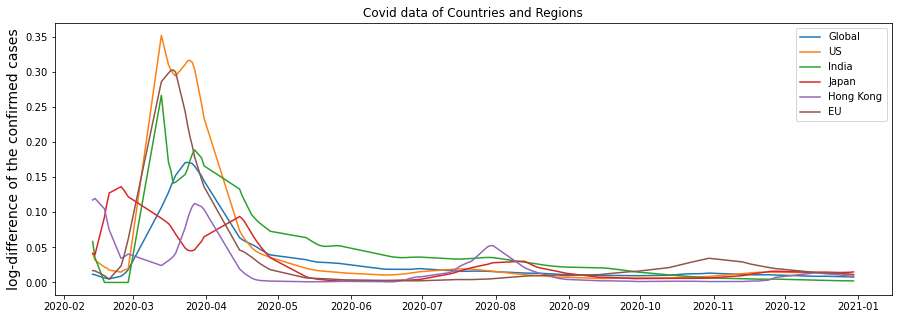

In [259]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index, data.loc[:, 'cases_growth_global'], label="Global")
ax.plot(data.index, data.loc[:, 'cases_growth_US'], label="US")
ax.plot(data.index, data.loc[:, 'cases_growth_India'], label="India")
ax.plot(data.index, data.loc[:, 'cases_growth_Japan'], label="Japan")
ax.plot(data.index, data.loc[:, 'cases_growth_HK'], label="Hong Kong")
ax.plot(data.index, data.loc[:, 'cases_growth_EU'], label="EU")
ax.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax.set_title('Covid data of Countries and Regions')
plt.legend()

Then, we will draw the covid data and the volatility data of each country or region(the later one will be drawn **with red line**) separately. And in each graph we will also draw the graph of the global covid data.

Here is the situation of VIX in the United States:

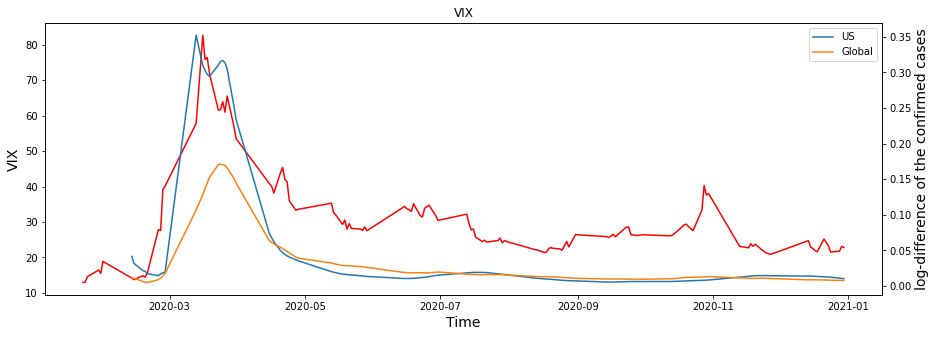

In [264]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index, data.VIX, color="red")
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("VIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_US'], label="US")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title("VIX")
plt.legend()
plt.show()

Here is the situation of IDVIX in India:

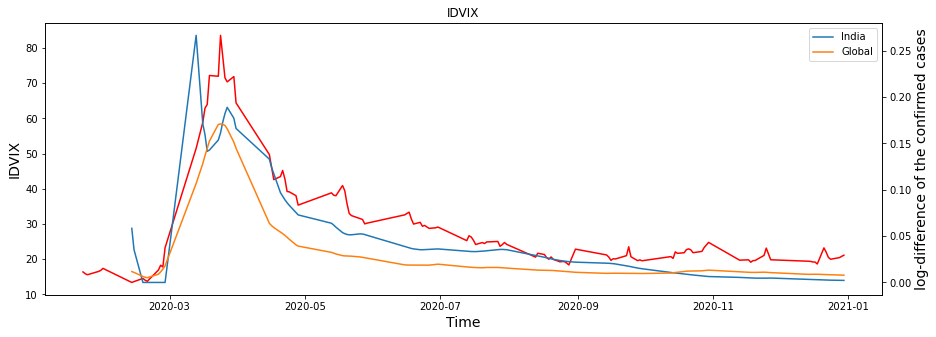

In [265]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index, data.IDVIX, color="red")
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("IDVIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_India'], label="India")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
#ax2.plot(data.index, data['cases_growth_India'], label='India')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title("IDVIX")
plt.legend()
plt.show()

Here is the situation of JPVIX in Japan:

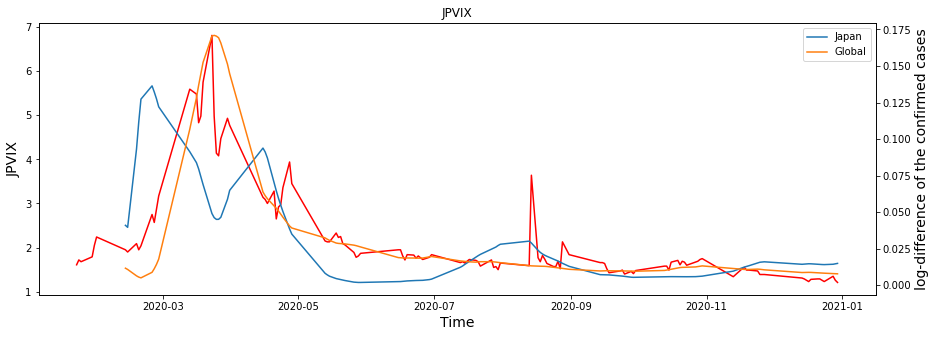

In [266]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index,data.JPVIX , color="red")
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("JPVIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_Japan'], label="Japan")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
#ax2.plot(data.index, data['cases_growth_Japan'], label='Japan')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title('JPVIX')
plt.legend()
plt.show()

Here is the situation of VHSI in Hong Kong:

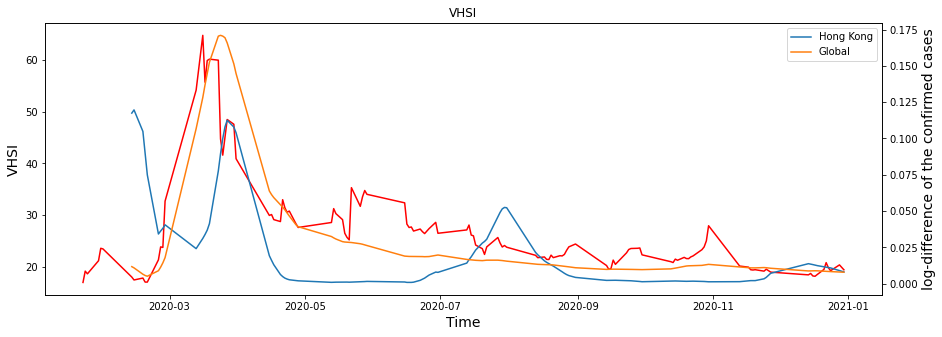

In [267]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index,data5.VHSI , color="red")
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("VHSI", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_HK'], label="Hong Kong")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
#ax2.plot(data.index, data['cases_growth_HK'], label='Hong Kong')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title('VHSI')
plt.legend()
plt.show()

Here is the situation of EUVIX in Eurozone:

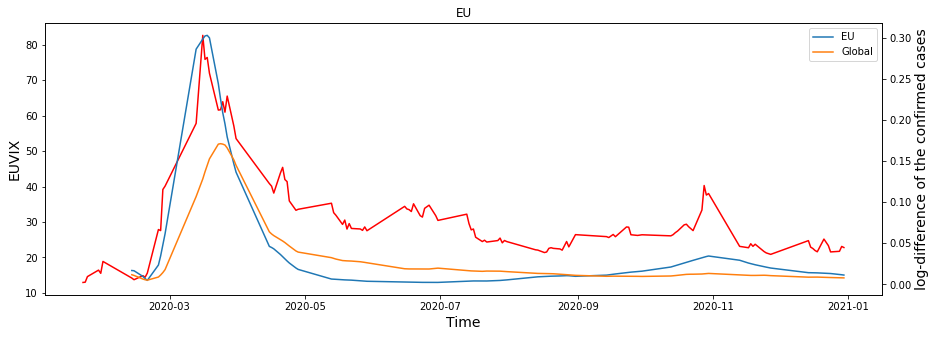

In [268]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index,data.EUVIX , color="red")
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("EUVIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_EU'], label="EU")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
#ax2.plot(data.index, data['cases_growth_EU'], label='EU')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title("EU")
plt.legend()
plt.show()

From all things above, we can learn something interesting:
* The growth of confirmed cases of all these countries/regions rise to a peak between March and April.Although Japan did not has a "peak period", its growth on confirmed rates between March and April is also greater than that of other period.
* With the growth of confirmed cases, these countries/regions volitility also rise to a peak almost in a simultaneous way.Japan may be a little different from that of others(Its volitility is much lower than others as we have shown),but the time between its "covid peak" and "VIX peak" is also very closed.
* All these volitilites rise to the peak almost at the same time as that of Global confirmed rate. Maybe it demonstrate that the financial markets in the world are connected closedly and the volitility may greatly depend on the global situation.